In [1]:
from __future__ import division, print_function
import joblib
import numpy as np
from glob import glob
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import shutil

In [12]:
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]

In [34]:
from rdkit.Chem import AllChem

data_dir = 'appendix/data/'

def make_data(tgt):
    
    ntgt = tgt
    if ntgt == 'JAK2':
        ntgt = 'JAK-2'
    fn = data_dir + ntgt + '/' + ntgt + '.sdf'
    
    dy_dict = {}
    
    unk = 2100 # way off into the future
    
    suppl = Chem.SDMolSupplier(fn)
    for mol in suppl:
        smi = Chem.MolToSmiles(mol)
        try:
            dy_dict[smi] = int(mol.GetProp('document_year'))
        except ValueError:
            dy_dict[smi] = unk
        pass
    
    sms = joblib.load('datasets/' + tgt + '/' + tgt + '.smiu')
    
    dy_out = np.asarray([dy_dict.get(x, unk) for x in sms])
    
    joblib.dump(dy_out, 'datasets/' + tgt + '/' + tgt + '.dyu')
    return

In [24]:
make_data('A2a')

In [26]:
a2a = joblib.load('datasets/A2a/A2a.dyu')

In [27]:
len(a2a)

199

In [28]:
sum(a2a < 2100)

92

In [35]:
for tgt in targets:
    make_data(tgt)

In [36]:
herg = joblib.load('datasets/HERG/HERG.dyu')

In [37]:
len(herg)

5010

In [38]:
len(herg < 2100)

5010

In [39]:
herg

array([2006, 2011, 2008, ..., 2014, 2015, 2009])

In [44]:
np.percentile(herg, 50)

2011.0

In [40]:
from IPython.display import SVG
from scipy.spatial.distance import pdist, squareform, jaccard, cityblock
from scipy import stats

from multiprocessing import Pool
from copy import deepcopy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model as LM

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge, ElasticNet, Lasso

from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR

# Deep learning model with intermediate layer...
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=100, batch_size=5, verbose=0)))

# Model dictionaries 
model_dict = {'ridge' : {'m' : Ridge, 'kw' : {'fit_intercept':True, 'alpha':0.1}, },
              'rf'    : {'m' : RandomForestRegressor, 'kw' : {'n_estimators':100, 
                                                              'n_jobs':4, 'max_depth':10}, },
              'svr'   : {'m' : SVR, 'kw' : {}, },
              
              'dl_l'   : {'m' : Pipeline, 
                          'kw' : {'steps': [('standardize', StandardScaler()),
                                            ('mlp', KerasRegressor(build_fn=larger_model, 
                                                                   epochs=100, batch_size=5, 
                                                                   verbose=0))
                                                           ]},
                         },
             }

# Datasets
from glob import glob
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]

import matplotlib.pyplot as plt
%pylab inline
figsize(20, 10)
import seaborn as sns

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [52]:
# Runs without deep learning are much faster - this controls use of DL
do_dl = True

In [53]:
# Arguments for overall number of runs
if not do_dl:
    # Take out when we want to run deep learning model
    del model_dict['dl_l']
    tot_num_runs = 400
    outdir = 'models_final/'
    fig_dir = 'figures/'
    ['svr', 'rf', 'ridge']
    model_labels = ['Support Vector Regression','Random Forests','Ridge Regression']
else:
    tot_num_runs = 100
    outdir = 'models_final_dl/'
    fig_dir = 'figures_dl/'
    model_labels = ['Support Vector Regression','Random Forests','Ridge Regression','Deep Learning']

In [41]:
# Pull in data for a single target name
def get_data(tgt_name='COX-2'):
    data_dir = 'datasets/' + tgt_name + '/'
    preds = joblib.load(data_dir + tgt_name + '_predsu.npy')
    resps = joblib.load(data_dir + tgt_name + '_respu.npy')
    smiles = joblib.load(data_dir + tgt_name + '.smiu')
    dy = joblib.load(data_dir + tgt_name + '.dyu')
    return preds, resps, smiles, dy

In [46]:
def get_fn(frac_fit, kf=0, insample=False, fig=False, loss=None, dy=False):
    fn = 'loss_' + str(frac_fit)
    if kf > 0:
        fn += '_kf_' + str(kf)
        pass
    if insample:
        fn += '_insample'
        pass
    if dy:
        fn += '_dy'
    od = fig_dir if fig else outdir
    ffn = os.path.join(od, fn)
    if fig:
        ffn = re.sub('[.]','', ffn)
        ffn = ffn + '_' + loss + '.pdf'
        pass
    return ffn

In [47]:
def full_bootstrap(preds, resps, method, num_runs=100, insample=False,
                  frac_fit=1.0, num_kf=0, use_pool=True, dy=None, single_sort=False):

    # losses is going to be a list of dicts, loss_type => value
    losses = []
    
    # You're doing time splitting...
    if dy is not None:
        sorted_indices = np.argsort(dy)
    else:
        sorted_indices = np.argsort(resps)
        pass
    
    N = len(resps)
    M = int(N * frac_fit)
    
    # Choose insample values...
    idx_list = []
    for i in range(num_runs):
        # You're doing a single run on the sorted points
        if single_sort:
            idcs = sorted_indices[:M]
        # You're doing cross-validation
        elif num_kf > 0:
            kf = KFold(n_splits=num_kf, shuffle=True)
            for (tr_i, tst_i) in kf.split(np.arange(M)):
                idcs = sorted_indices[tr_i]
                pass
            pass
        # You're bootstrapping
        else:
            idcs_rand = np.random.choice(M, M)
            idcs = sorted_indices[idcs_rand]
            pass
        idx_list.append({'is' : idcs})
        pass
    
    # Add in all the other data...
    for d in idx_list:
        if insample:
            oos = d['is']
        else:
            oos = np.delete(np.arange(N), d['is'])
            pass
        d.update({'oos' : oos, 'preds' : preds, 
                  'resps' : resps, 'method' : method})
        pass
            
    if use_pool:
        p = Pool(7)
        losses = p.map(nbs_run, idx_list)
        p.close()
        p.join()
    else:
        losses = [nbs_run(x) for x in idx_list]
        pass
    return losses

In [50]:
def runner(frac_fit=1.0, kf=0, insample=False, use_pool=True, dy_split=False):

    fnf = get_fn(frac_fit, kf=kf, insample=insample, dy=dy_split)
    if os.path.isfile(fnf) and not force_rerun:
        print('Already computed')
        return

    loss_hdr = {}
    if insample:
        num_runs = 1
    elif kf > 0:
        num_runs = int(tot_num_runs/kf)
    else:
        num_runs = tot_num_runs
    
    single_sort=False
    # just run single fit
    if dy_split:
        num_runs = 1
        single_sort=True
    
    for tgt in sorted_targets:
        loss_hdr[tgt] = {}
        print ('Doing', tgt)
        preds, resps, _, dy_data = get_data(tgt)
        dy=None if not dy_split else dy_data
        
        preds = preds + 0.
        for m in model_dict.keys():
            res = full_bootstrap(preds, resps, m, frac_fit=frac_fit, num_kf=kf,
                                 insample=insample, num_runs=num_runs, use_pool=use_pool,
                                 dy=dy, single_sort=single_sort,
                                )
            detail_fn = outdir + '/detail/' + tgt + '_' + m + '_' + str(frac_fit) + '_' + str(kf) 
            if insample:
                detail_fn += '_insample'
            if dy_split:
                detail_fn += '_dy'
            detail_fn += '.res'
            joblib.dump(res, detail_fn)
            loss_hdr[tgt][m] = jackknife_summary(res)
        pass
    joblib.dump(loss_hdr, fnf)
    print('Completed')
    return

In [57]:
def avg_mse(predictions, responses, **kwargs):
    return mean_squared_error(responses, predictions) / mean_squared_error(responses, np.zeros_like(responses))


def Rank_loss(predictions, responses, **kwargs):
    
    tgt_val = kwargs.get('tgt_val')
    ranked = np.argsort(-predictions)
    found = responses[ranked] >= tgt_val
    # Number of actives
    N_gamma = np.sum(found)
    
    # Size of test sets
    N_test = predictions.shape[0]
    lt = kwargs.get('loss_type')
    #pdb.set_trace()
    if lt == 'min':
        # Equation (1) of the paper
        loss = 1/(N_test - N_gamma) * np.min(np.arange(N_test)[found])
    elif lt == 'avg':
        # Equation (2) of the paper
        loss = 1/N_gamma * 1/(N_test - N_gamma) * (np.sum(np.arange(N_test)[found]) - N_gamma * (N_gamma - 1)/2)
        pass
    
    assert loss >= 0
    assert loss <= 1
    return loss


def Active_rank_loss_avg(predictions, responses, **kwargs):
    kwargs.update({'loss_type' :'avg'})
    return Rank_loss(predictions, responses, **kwargs)

def Active_rank_loss_min(predictions, responses, **kwargs):
    kwargs.update({'loss_type' :'min'})
    return Rank_loss(predictions, responses, **kwargs)


In [58]:
import os.path
import re

# define the dictionary of losses used here
loss_dict = {'mse' :       {'func' : avg_mse,         'kw' : {}},
             'loss_min_90' :   {'func' : Active_rank_loss_min,  'kw' : {'frac_find' : 0.9}},
             'loss_avg_90' :   {'func' : Active_rank_loss_avg,  'kw' : {'frac_find' : 0.9}},
             'loss_min_95' :   {'func' : Active_rank_loss_min,  'kw' : {'frac_find' : 0.95}},
             'loss_avg_95' :   {'func' : Active_rank_loss_avg,  'kw' : {'frac_find' : 0.95}},
             'loss_min_99' :   {'func' : Active_rank_loss_min,  'kw' : {'frac_find' : 0.99}},
             'loss_avg_99' :   {'func' : Active_rank_loss_avg,  'kw' : {'frac_find' : 0.99}},
            }

In [60]:
sorted_targets = sorted(targets, key=lambda x: len(get_data(x)[0]))

In [62]:
def nbs_run(kwargs):
    my_is = kwargs.get('is')
    my_oos = kwargs.get('oos')
    method = kwargs.get('method')
    preds = kwargs.get('preds') + 0.
    resps = kwargs.get('resps')
    
    mdl = model_dict[method]['m'](**model_dict[method]['kw'])
    mdl.fit(preds[my_is], resps[my_is])
        
    predictions = mdl.predict(preds[my_oos])
    
    losses = {}
    for (l, v) in loss_dict.iteritems():
        
        # Worth noting, we're looking for the top frac_find _in_the_oos_data_
        # (not in the whole data - as otherwise we might be looking for something
        # that isn't there)
        if 'frac_find' in v['kw']:
            N = len(resps[my_oos])
            sorted_indices = np.argsort(resps[my_oos])
            n = int(N * v['kw']['frac_find'])
            tgt_val = resps[my_oos][sorted_indices[n]]
            v['kw'].update({'tgt_val' : tgt_val})
            
        losses[l] = v['func'](predictions, resps[my_oos], **v['kw'])
        pass
    
    return losses

In [64]:
# This function takes the vector of observed values and their mean (implies fewer computations of the mean)
def jackknife(vals, vals_bar):
    n = len(vals)
    var_JK = 0.0
    for v in vals:
        vals_bar_i = (n/(n-1)) * (vals_bar - v/n)
        #print(pow(vals_bar_i - vals_bar, 2))
        var_JK += pow(vals_bar_i - vals_bar, 2)
        pass

    sd_JK = pow( ((n-1)/n) * var_JK, .5)
   
    return sd_JK
    
def jackknife_summary(results):
    summary = {}
    for l in loss_dict.keys():
        vals = np.asarray([x[l] for x in results])
        if len(vals) == 1:
            summary[l] = {'loss' : vals[0]}
        else:
            vals_bar = np.mean(vals)
            sd = jackknife(vals, vals_bar)
            summary[l] = {'loss_l' : vals_bar - 2*sd,
                          'loss' : vals_bar,                          
                          'loss_u' : vals_bar + 2*sd,
                         }
            pass
        pass
    return summary

In [65]:
runner(frac_fit=0.7, use_pool=False, dy_split=True)

Doing A2a
Doing Dopamine
Doing Dihydrofolate
Doing Carbonic
Doing ABL1
Doing opioid
Doing Cannabinoid
Doing Androgen
Doing COX-1
Doing Monoamine
Doing LCK
Doing Glucocorticoid
Doing Ephrin
Doing Caspase
Doing Coagulation
Doing Estrogen
Doing B-raf
Doing Glycogen
Doing Vanilloid
Doing Aurora-A
Doing JAK2
Doing COX-2
Doing Acetylcholinesterase
Doing erbB1
Doing HERG
Completed


In [68]:
# Plots results
# Added put_title arg for plots for paper
def plotter(frac_fit=1.0, kf=0, insample=False, loss='mse', save=True, put_title=False, 
            put_grid=False, dy_split=False):
    
    fnf = get_fn(frac_fit, kf=kf, insample=insample, dy=dy_split)
    
    loss_hdr = joblib.load(fnf)
   
    for (i, method) in enumerate(model_dict.keys()):

        #losses = np.asarray([loss_hdr[x][method][loss]['loss'] for x in sorted_targets])
        losses = []
        for x in sorted_targets:
            try:
                losses.append(loss_hdr[x][method][loss]['loss'])
            except:
                print(x, method, loss)
                raise KeyError
        losses = np.asarray(losses)
        if insample or dy_split:
            plot(np.arange(25) + 0.05*i, losses,  label=method.upper())
        else:
            loss_l = np.asarray([loss_hdr[x][method][loss]['loss_l'] for x in sorted_targets])
            loss_u = np.asarray([loss_hdr[x][method][loss]['loss_u'] for x in sorted_targets])
            
            yerr = np.vstack((losses - loss_l, loss_u - losses))
            
            errorbar(np.arange(25)+i*0.1, losses, capsize=10, yerr=yerr, label=method.upper())
            pass
        pass
        
    if insample:
        if put_title:
            title('Insample %s Loss' % loss.upper())
    else:
        ttl = 'OOS %s Loss' % loss.upper()
        if kf > 0:
            ttl += ' with %d fold CV' % kf
        if frac_fit < 1.0:
            if dy_split:
                'Split on discovery year at %.1f fraction'
            else:
                ttl += ' Max activity in fit at %.1f' % frac_fit
        if put_title:
            title(ttl)
    pass

    grid(put_grid)
    plt.tick_params(top=False, right=False)
    plt.xticks(np.arange(25), sorted_targets, rotation=-45)
    plt.legend(loc='best', fontsize = 'x-large', labels=model_labels)
    if loss=='mse':
        plt.ylabel('Expected mean squared error', fontsize='x-large')
    else:
        plt.ylabel('Expected loss', fontsize='x-large')
    
    if save:
        fnff = get_fn(frac_fit, kf=kf, insample=insample, fig=True, loss=loss)
        print(fnff)
        savefig(fnff, bbox_inches='tight')

In [70]:
figsize(20, 10)

figures_dl/loss_07_mse.pdf


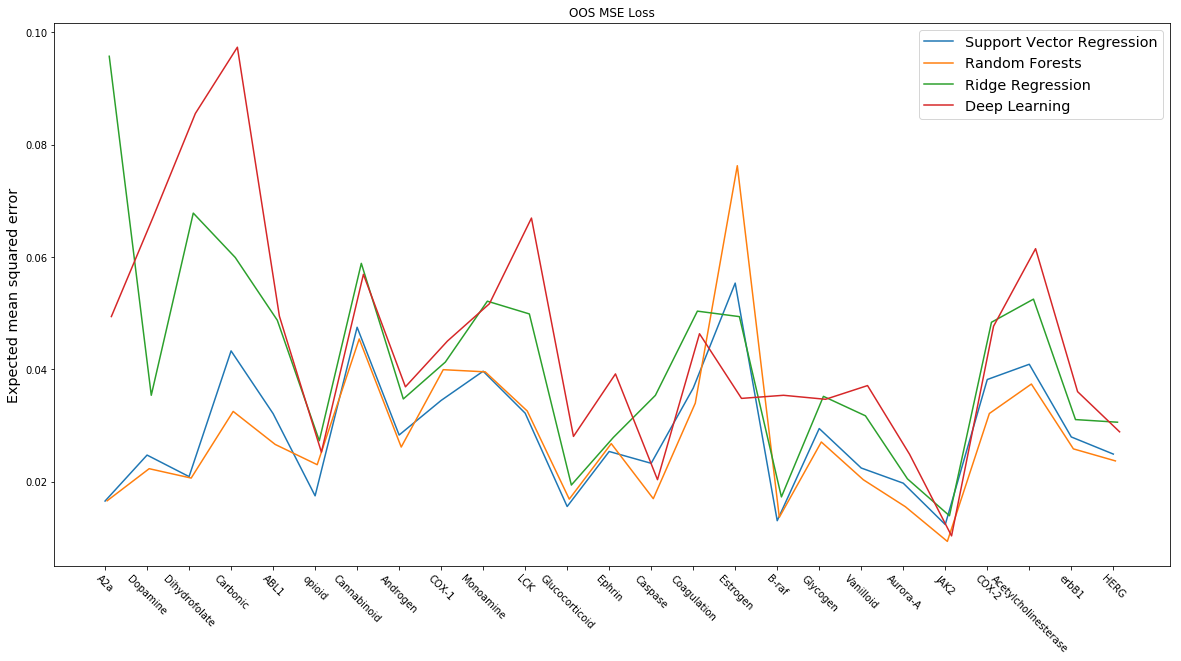

In [72]:
plotter(frac_fit=0.7, dy_split=True, put_title=True)

figures_dl/loss_07_loss_avg_90.pdf


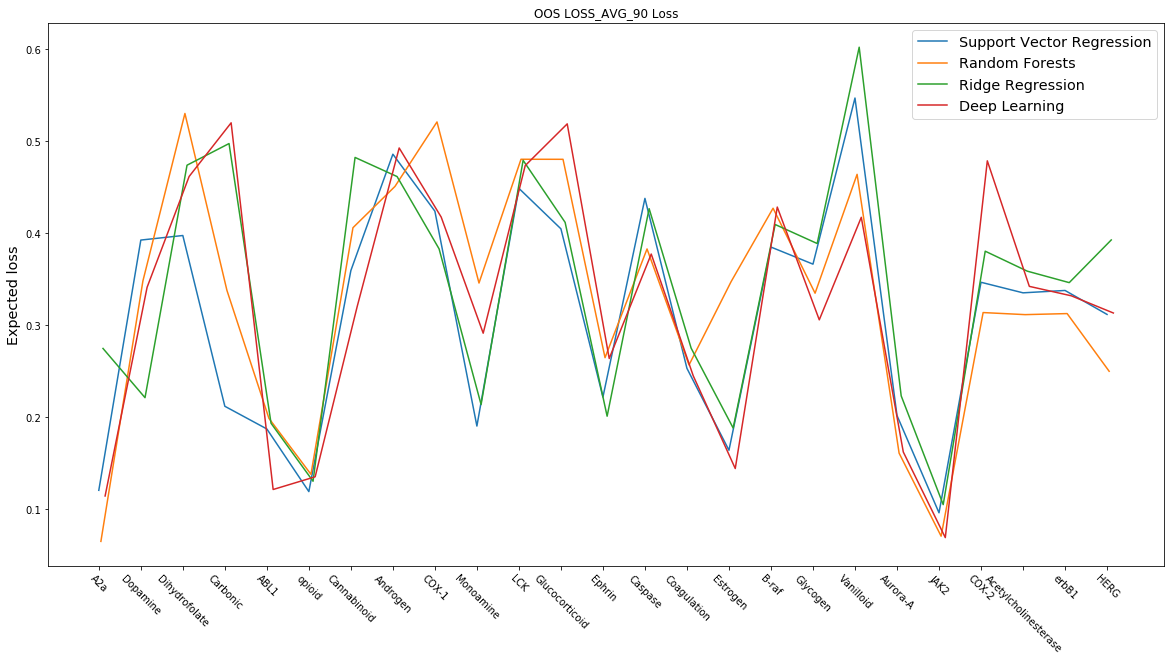

In [73]:
plotter(frac_fit=0.7, dy_split=True, put_title=True, loss='loss_avg_90')

figures_dl/loss_07_loss_avg_95.pdf


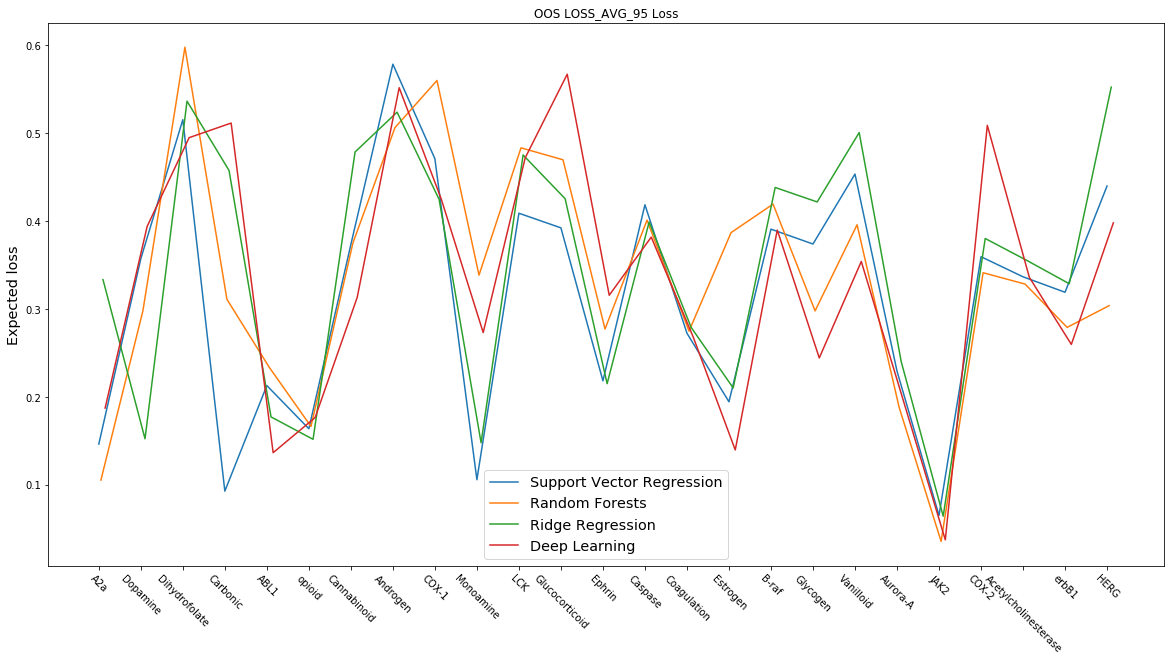

In [74]:
plotter(frac_fit=0.7, dy_split=True, put_title=True, loss='loss_avg_95')

figures_dl/loss_07_loss_min_90.pdf


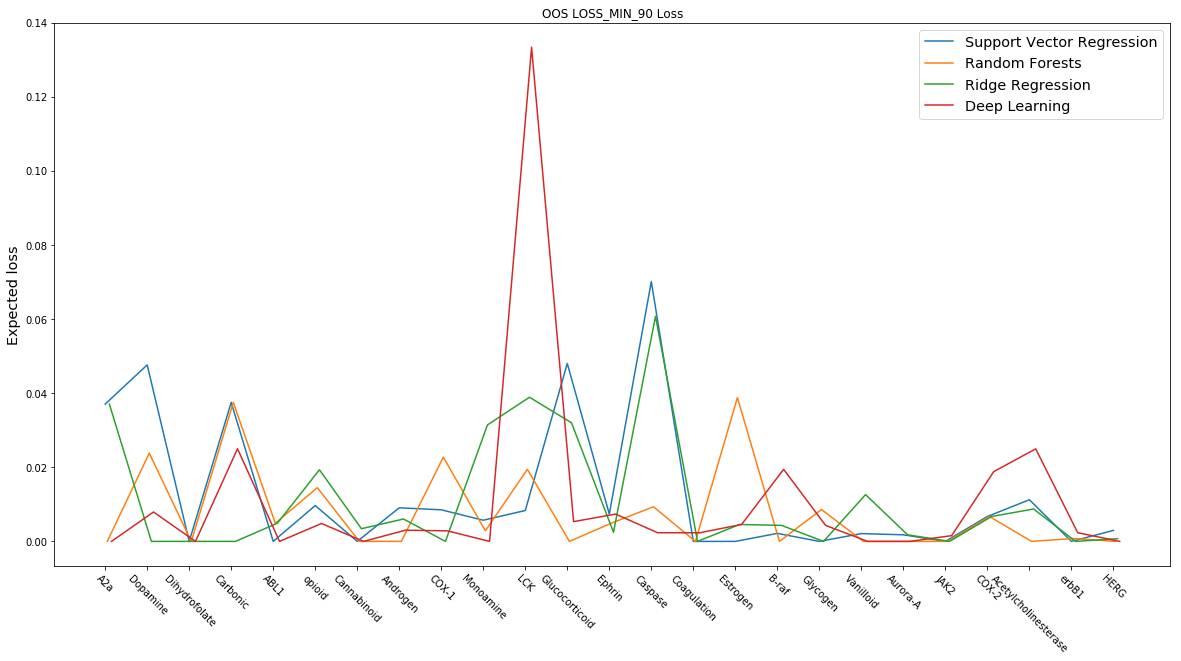

In [75]:
plotter(frac_fit=0.7, dy_split=True, put_title=True, loss='loss_min_90')

figures_dl/loss_07_loss_min_95.pdf


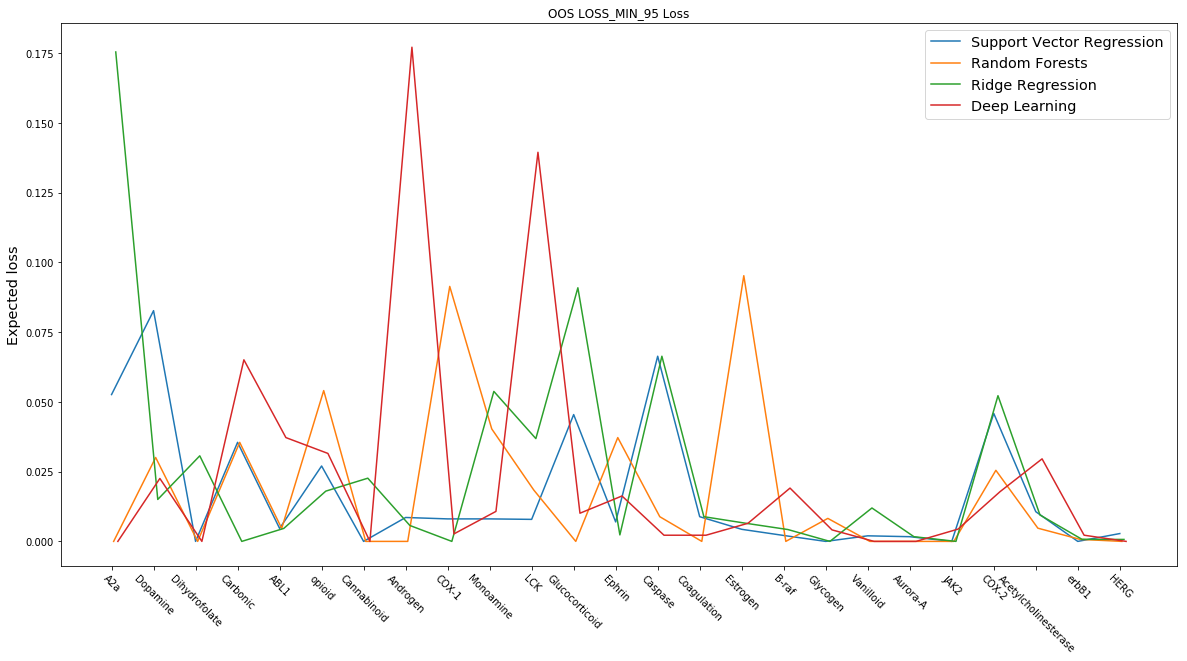

In [76]:
plotter(frac_fit=0.7, dy_split=True, put_title=True, loss='loss_min_95')